# Heart Disease Classification: A Comprehensive Analysis

## Introduction

### Background
Heart disease remains one of the leading causes of mortality worldwide. Early and accurate diagnosis is crucial for effective treatment and improved patient outcomes. Machine learning models can assist healthcare professionals in identifying patients at risk by analyzing various clinical and demographic features.

### Objective
This notebook aims to develop and compare three machine learning models (Logistic Regression, K-Nearest Neighbors, and Support Vector Machine) for heart disease classification. We will evaluate their performance across different demographic groups and provide recommendations for clinical application.

### Metrics: Sensitivity and Specificity
In clinical settings, two metrics are particularly important:

- **Sensitivity (Recall)**: The ability to correctly identify patients with heart disease
  - Formula: TP / (TP + FN)
  - Clinical importance: Minimizes missed diagnoses (false negatives)

- **Specificity**: The ability to correctly identify patients without heart disease
  - Formula: TN / (TN + FP)
  - Clinical importance: Minimizes unnecessary treatments (false positives)

## Data Loading & Exploration


In [19]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.model_selection import GridSearchCV
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [20]:
# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Load datasets
train_data = pd.read_csv('heart_train.csv')
val_data = pd.read_csv('heart_val.csv')
test_data = pd.read_csv('heart_test.csv')

# Display basic information
print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {val_data.shape}")
print(f"Test set shape: {test_data.shape}")

# Rename columns for clarity
column_names = ['age', 'gender', 'feature3', 'feature4', 'feature5',
                'feature6', 'feature7', 'feature8', 'feature9', 'feature10',
                'feature11', 'feature12', 'feature13', 'target']
train_data.columns = column_names
val_data.columns = column_names
test_data.columns = column_names

# Display first few rows
train_data.head()

Training set shape: (513, 14)
Validation set shape: (256, 14)
Test set shape: (256, 14)


,age,gender,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


### Data Structure and Summary Statistics

In [21]:
# Check data types
print("Data Types:")
print(train_data.dtypes)

# Summary statistics for numerical features
print("\nSummary Statistics for Numerical Features:")
numerical_cols = ['age', 'feature4', 'feature5', 'feature8', 'feature10']
train_data[numerical_cols].describe()

Data Types:
age            int64
gender         int64
feature3       int64
feature4       int64
feature5       int64
feature6       int64
feature7       int64
feature8       int64
feature9       int64
feature10    float64
feature11      int64
feature12      int64
feature13      int64
target         int64
dtype: object

Summary Statistics for Numerical Features:


,age,feature4,feature5,feature8,feature10
count,513.000000,513.000000,513.000000,513.000000,513.000000
mean,53.902534,132.497076,247.810916,150.157895,1.038791
std,9.246529,18.308780,55.403186,23.235387,1.179461
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.000000,120.000000,211.000000,137.000000,0.000000
50%,55.000000,130.000000,243.000000,152.000000,0.800000
75%,60.000000,140.000000,282.000000,168.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


### Visualize Distributions

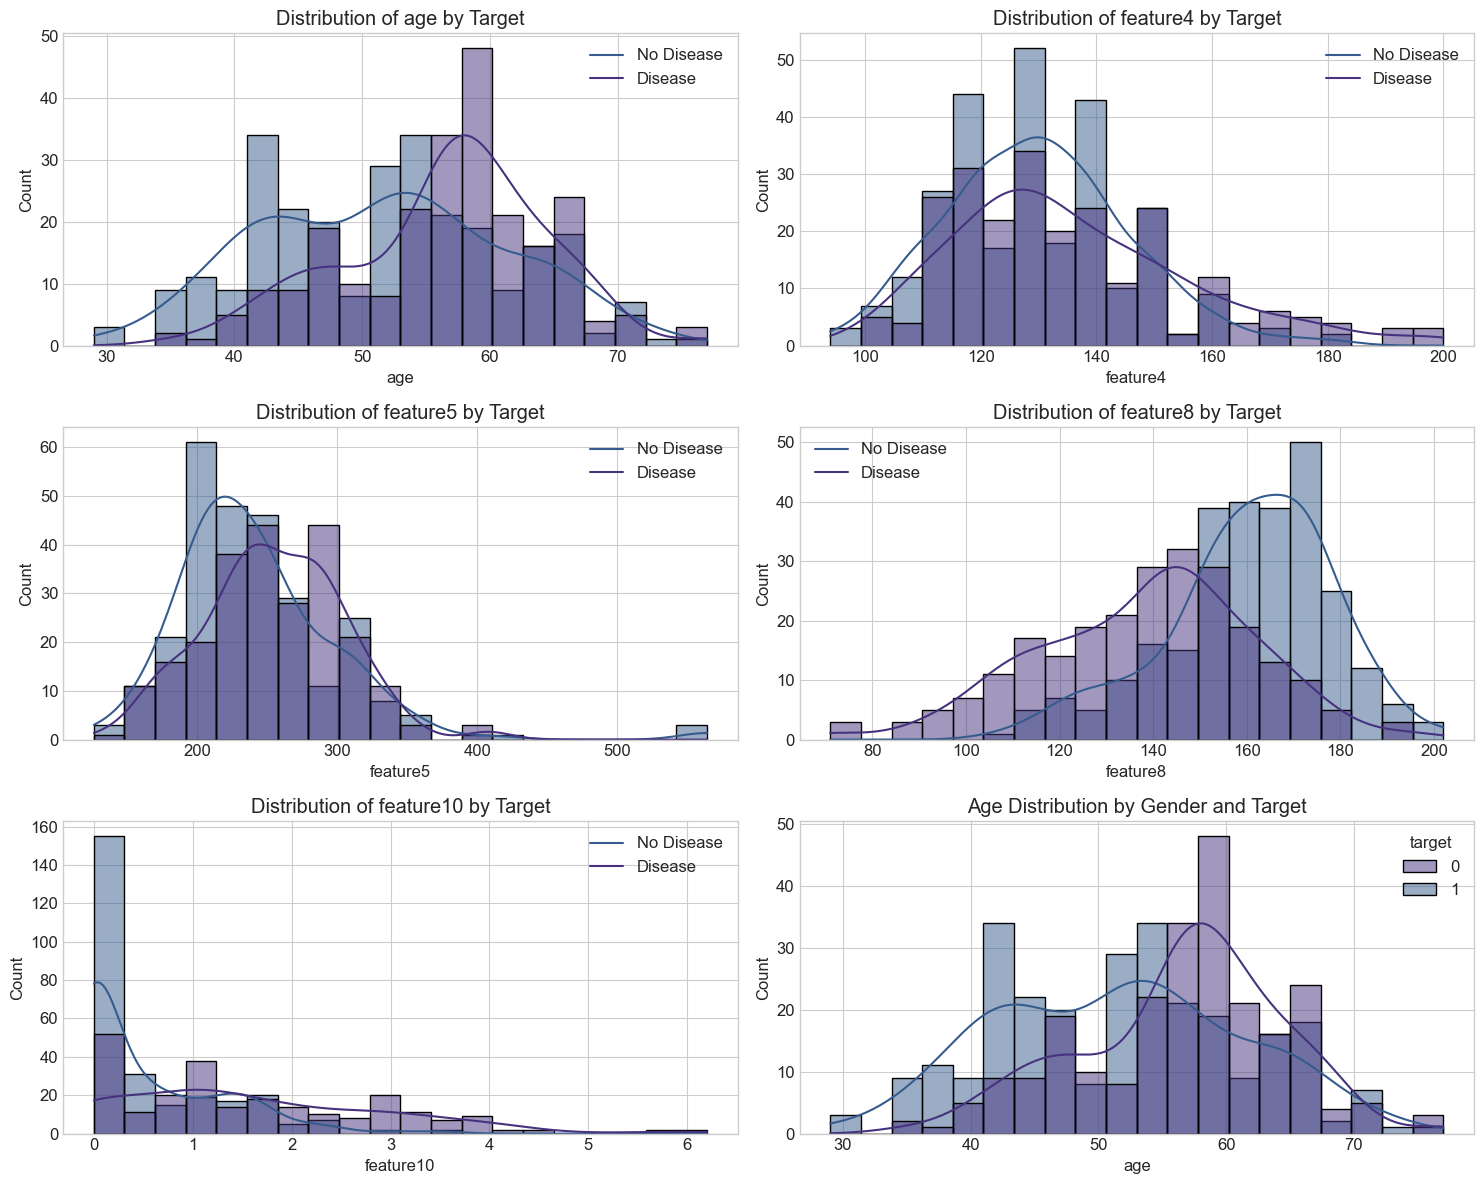

In [22]:
# Distribution of numerical features
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    if i < len(axes):
        sns.histplot(data=train_data, x=col, hue='target', bins=20, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col} by Target')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        axes[i].legend(['No Disease', 'Disease'])

# Distribution of age by gender and target
sns.histplot(data=train_data, x='age', hue='target',
             bins=20, kde=True, ax=axes[5])
axes[5].set_title('Age Distribution by Gender and Target')

plt.tight_layout()
plt.show()

### Categorical Value Counts

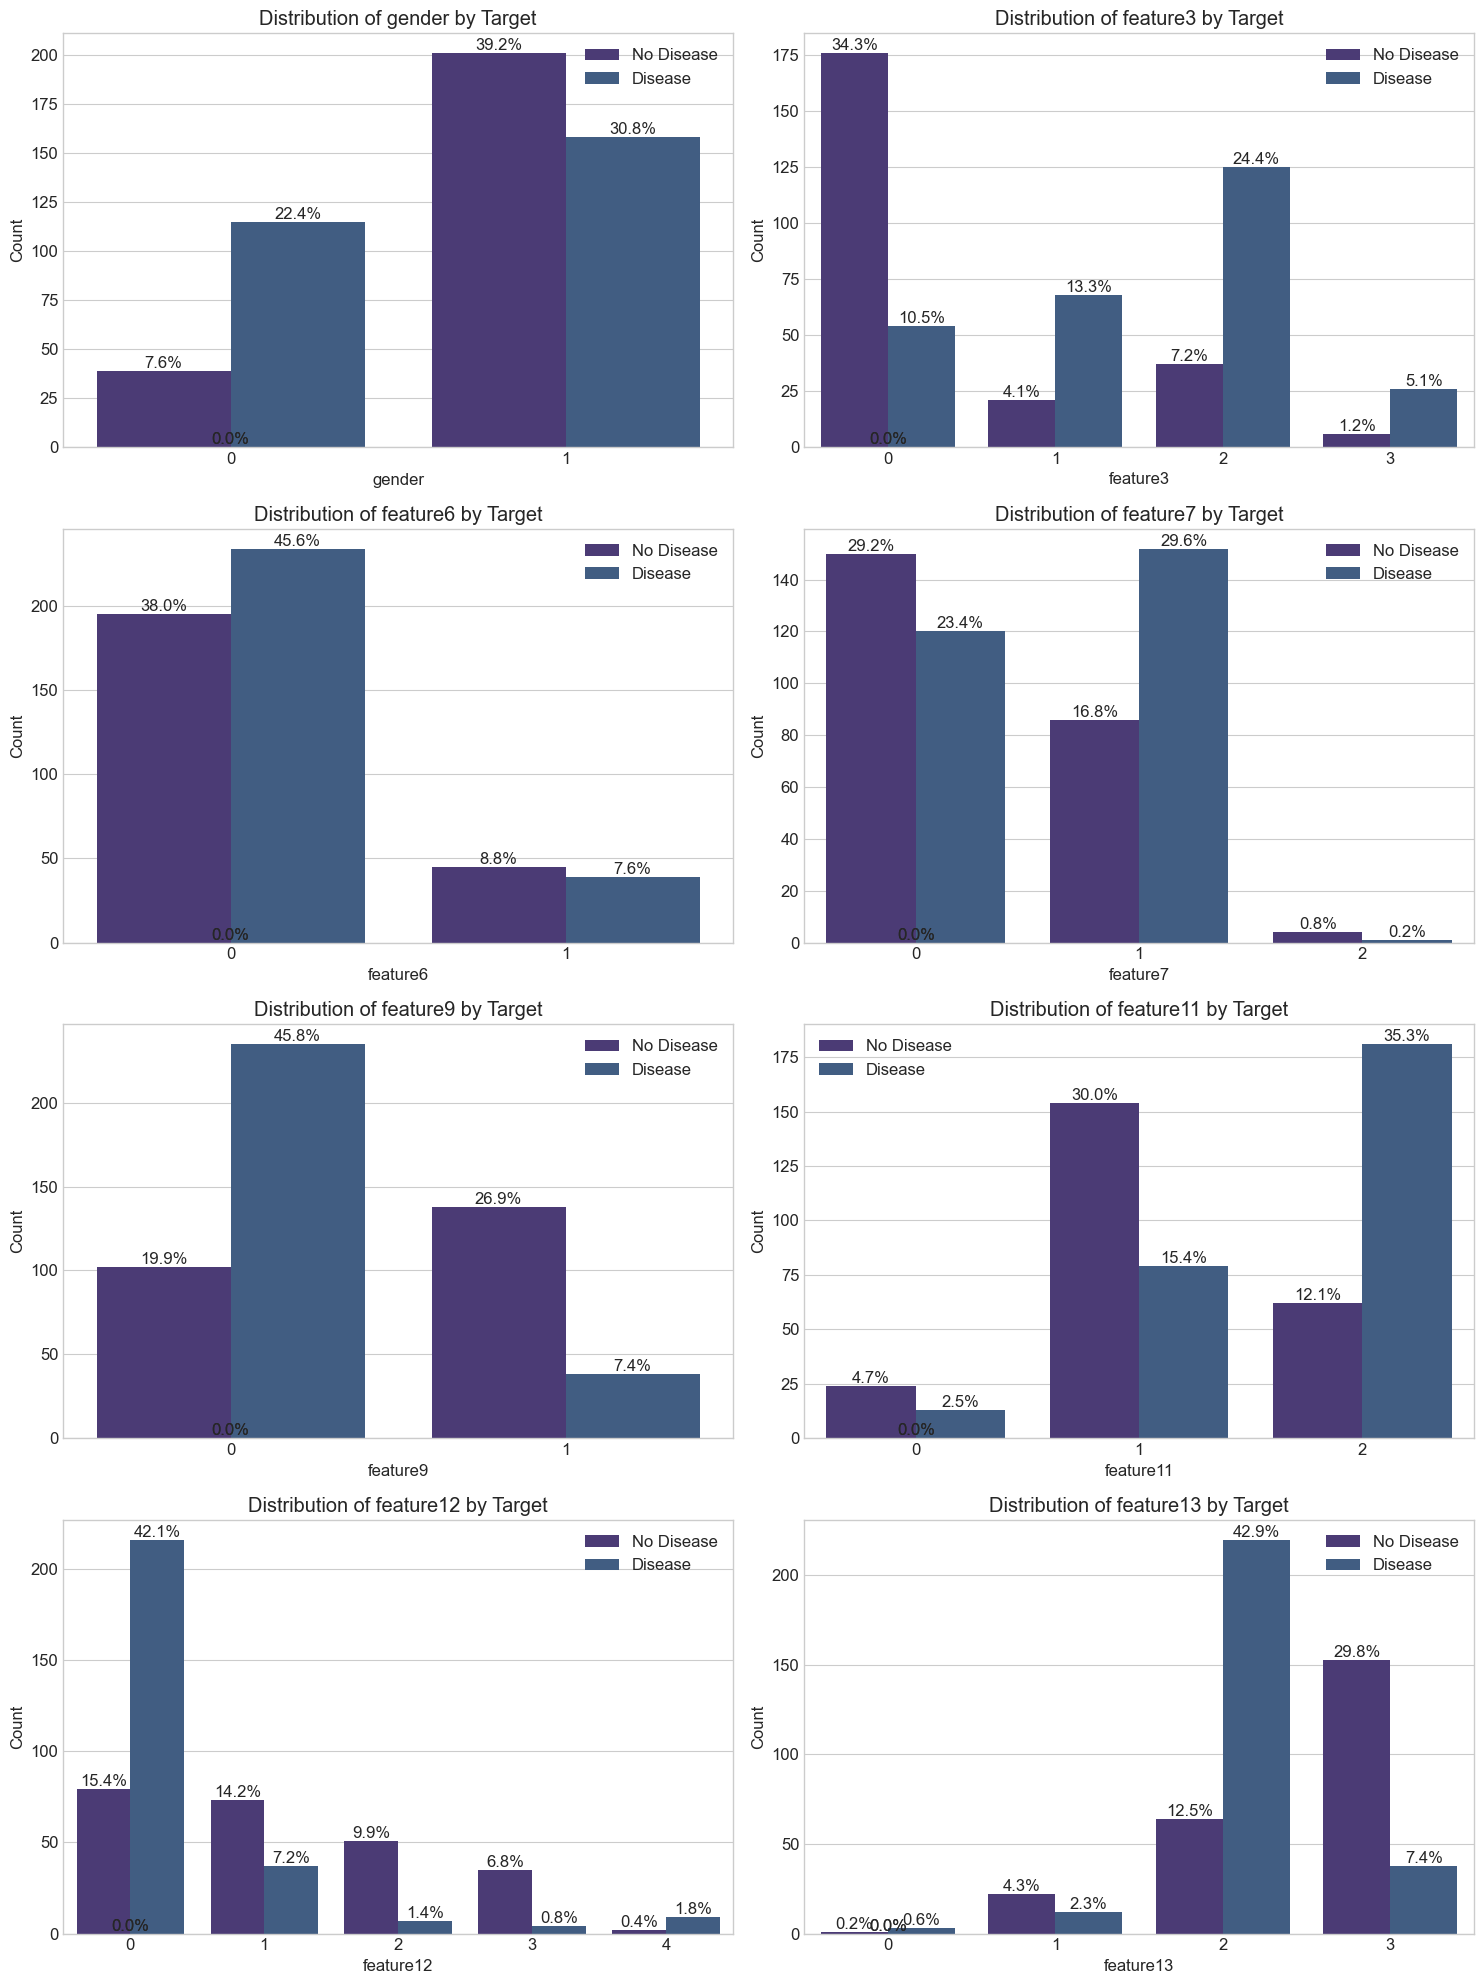

In [23]:
# Categorical features
categorical_cols = ['gender', 'feature3', 'feature6', 'feature7', 'feature9',
                    'feature11', 'feature12', 'feature13']

# Create plots for categorical features
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    # Count plot
    sns.countplot(data=train_data, x=col, hue='target', ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Target')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].legend(['No Disease', 'Disease'])

    # Add percentage labels
    total = len(train_data[col])
    for p in axes[i].patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        axes[i].annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Check for Missing Values

Missing Values in Training Set:
age          0
gender       0
feature3     0
feature4     0
feature5     0
feature6     0
feature7     0
feature8     0
feature9     0
feature10    0
feature11    0
feature12    0
feature13    0
target       0
dtype: int64


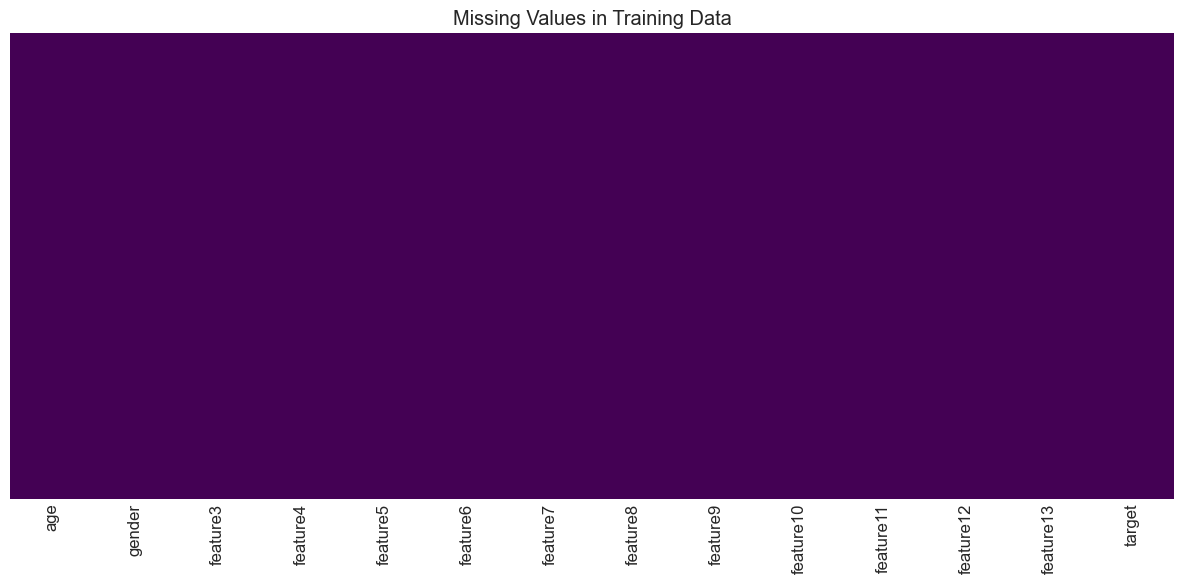

In [24]:
# Check for missing values
missing_values = train_data.isnull().sum()
print("Missing Values in Training Set:")
print(missing_values)

# Visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(train_data.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values in Training Data')
plt.tight_layout()
plt.show()

## Preprocessing

### Handle Missing Data

In [25]:

# Check if there are any missing values that need handling
if train_data.isnull().sum().sum() > 0:
    # For numerical features, impute with median
    for col in numerical_cols:
        if train_data[col].isnull().sum() > 0:
            median_value = train_data[col].median()
            train_data[col].fillna(median_value, inplace=True)
            val_data[col].fillna(median_value, inplace=True)
            test_data[col].fillna(median_value, inplace=True)

    # For categorical features, impute with mode
    for col in categorical_cols:
        if train_data[col].isnull().sum() > 0:
            mode_value = train_data[col].mode()[0]
            train_data[col].fillna(mode_value, inplace=True)
            val_data[col].fillna(mode_value, inplace=True)
            test_data[col].fillna(mode_value, inplace=True)
else:
    print("No missing values found in the dataset.")


No missing values found in the dataset.


### Feature Engineering and Preprocessing

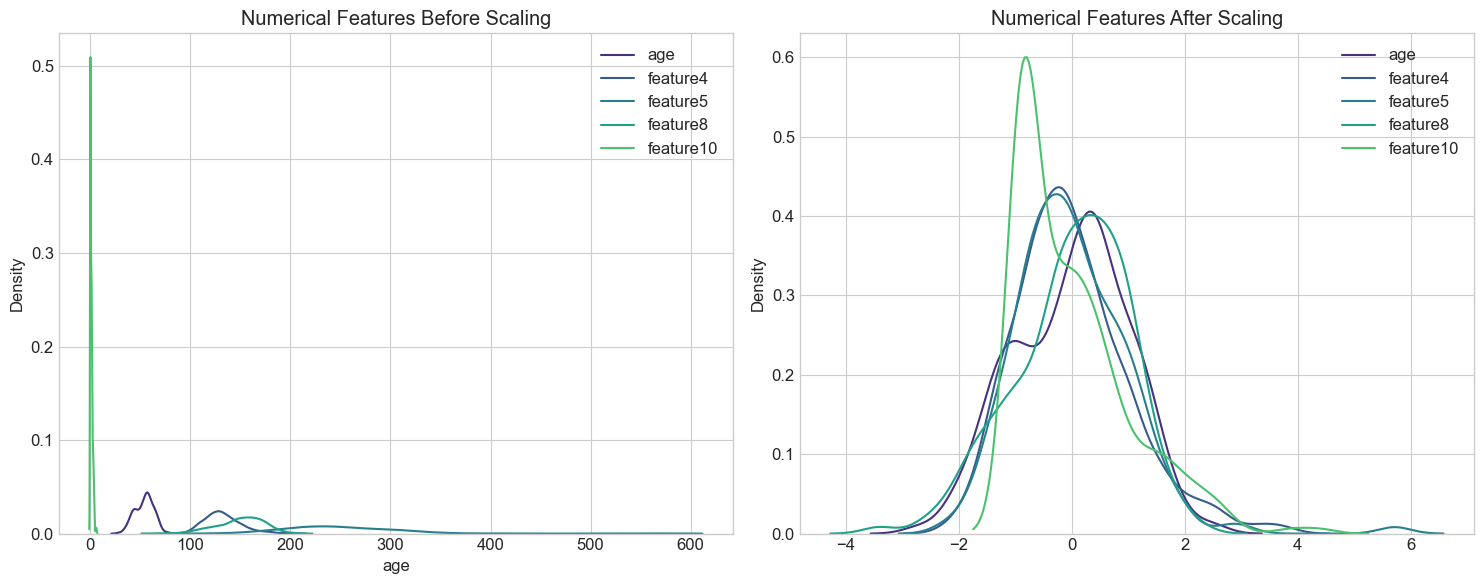

In [26]:

# Define feature types
numerical_features = ['age', 'feature4', 'feature5', 'feature8', 'feature10']
categorical_features = ['gender', 'feature3', 'feature6', 'feature7', 'feature9',
                        'feature11', 'feature12', 'feature13']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Prepare data
X_train = train_data.drop('target', axis=1)
y_train = train_data['target']
X_val = val_data.drop('target', axis=1)
y_val = val_data['target']
X_test = test_data.drop('target', axis=1)
y_test = test_data['target']

# Fit preprocessor on training data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after preprocessing
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(ohe_feature_names)

# Show effect of scaling with visualization
plt.figure(figsize=(15, 6))

# Before scaling
plt.subplot(1, 2, 1)
for i, col in enumerate(numerical_features):
    sns.kdeplot(X_train[col], label=col)
plt.title('Numerical Features Before Scaling')
plt.legend()

# After scaling
plt.subplot(1, 2, 2)
for i, col in enumerate(numerical_features):
    sns.kdeplot(X_train_processed[:, i], label=col)
plt.title('Numerical Features After Scaling')
plt.legend()

plt.tight_layout()
plt.show()


## Modeling and Hyperparameter Tuning

### Logistic Regression

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/niralpatel/Desktop/Krupali Assingments/env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/niralpatel/Desktop/Krupali Assingments/env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/niralpatel/Desktop/Krupali Assingments/env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/niralpatel/Desktop/Krupali Assingments/env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/niralpatel/Desktop/Krupali Assingments/env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None

Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.9505
Validation Sensitivity: 0.9231
Validation Specificity: 0.8651
Validation Accuracy: 0.8945


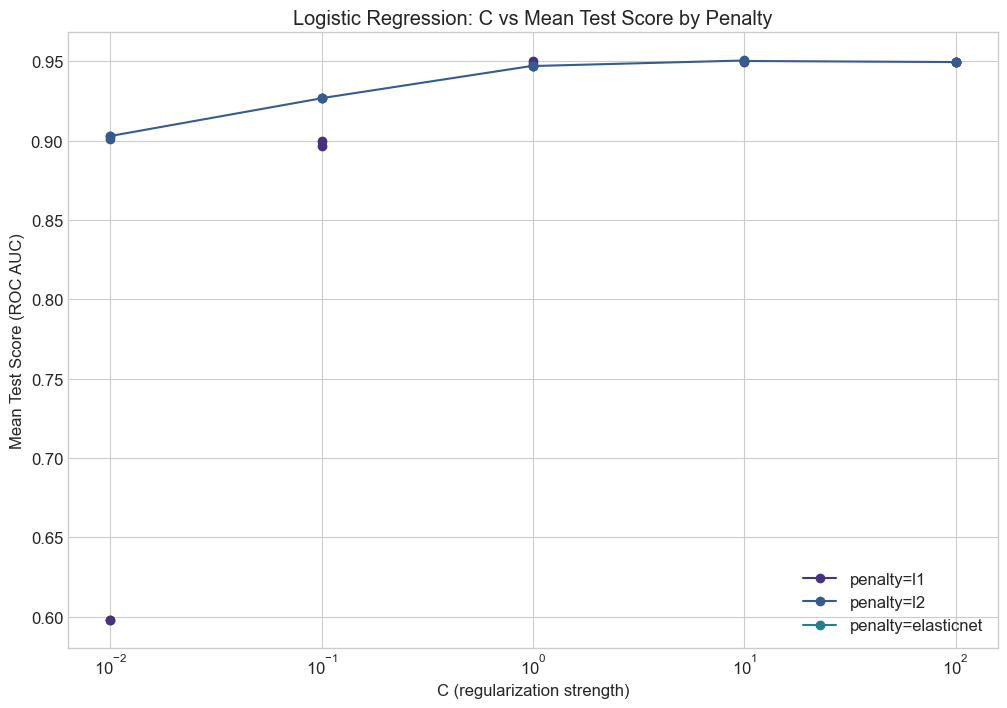

In [27]:

# Define the model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Define hyperparameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['liblinear', 'saga', 'lbfgs']
}

# Create grid search
grid_search_lr = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit grid search to training data
grid_search_lr.fit(X_train_processed, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search_lr.best_params_}")
print(f"Best cross-validation score: {grid_search_lr.best_score_:.4f}")

# Evaluate on validation set
lr_val_pred = grid_search_lr.predict(X_val_processed)
lr_val_prob = grid_search_lr.predict_proba(X_val_processed)[:, 1]

# Calculate metrics
lr_val_cm = confusion_matrix(y_val, lr_val_pred)
lr_val_sensitivity = lr_val_cm[1, 1] / (lr_val_cm[1, 1] + lr_val_cm[1, 0])
lr_val_specificity = lr_val_cm[0, 0] / (lr_val_cm[0, 0] + lr_val_cm[0, 1])
lr_val_accuracy = accuracy_score(y_val, lr_val_pred)

print(f"Validation Sensitivity: {lr_val_sensitivity:.4f}")
print(f"Validation Specificity: {lr_val_specificity:.4f}")
print(f"Validation Accuracy: {lr_val_accuracy:.4f}")

# Visualize hyperparameter tuning results
results_lr = pd.DataFrame(grid_search_lr.cv_results_)

# Plot C parameter vs mean test score for different penalties
plt.figure(figsize=(12, 8))
for penalty in results_lr['param_penalty'].unique():
    if penalty is not None:  # Skip None penalty
        subset = results_lr[results_lr['param_penalty'] == penalty]
        plt.semilogx(subset['param_C'], subset['mean_test_score'], marker='o', label=f'penalty={penalty}')

plt.title('Logistic Regression: C vs Mean Test Score by Penalty')
plt.xlabel('C (regularization strength)')
plt.ylabel('Mean Test Score (ROC AUC)')
plt.legend()
plt.grid(True)
plt.show()


### K-Nearest Neighbors

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
Best cross-validation score: 0.9830
Validation Sensitivity: 0.9231
Validation Specificity: 0.9683
Validation Accuracy: 0.9453


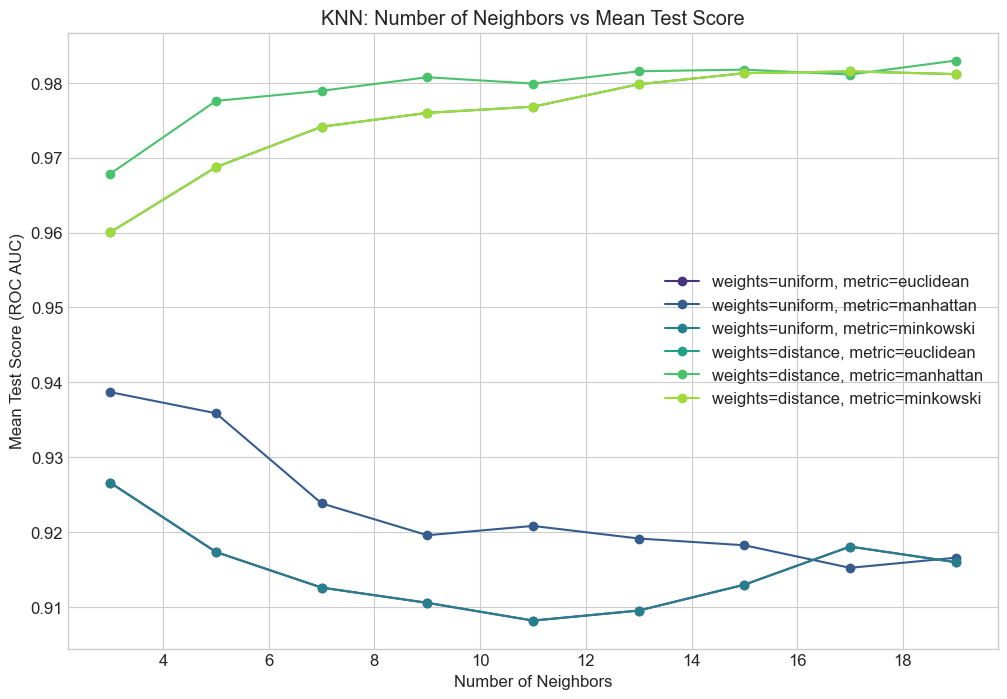

In [28]:

# Define the model
knn = KNeighborsClassifier()

# Define hyperparameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create grid search
grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit grid search to training data
grid_search_knn.fit(X_train_processed, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search_knn.best_params_}")
print(f"Best cross-validation score: {grid_search_knn.best_score_:.4f}")

# Evaluate on validation set
knn_val_pred = grid_search_knn.predict(X_val_processed)
knn_val_prob = grid_search_knn.predict_proba(X_val_processed)[:, 1]

# Calculate metrics
knn_val_cm = confusion_matrix(y_val, knn_val_pred)
knn_val_sensitivity = knn_val_cm[1, 1] / (knn_val_cm[1, 1] + knn_val_cm[1, 0])
knn_val_specificity = knn_val_cm[0, 0] / (knn_val_cm[0, 0] + knn_val_cm[0, 1])
knn_val_accuracy = accuracy_score(y_val, knn_val_pred)

print(f"Validation Sensitivity: {knn_val_sensitivity:.4f}")
print(f"Validation Specificity: {knn_val_specificity:.4f}")
print(f"Validation Accuracy: {knn_val_accuracy:.4f}")

# Visualize hyperparameter tuning results
results_knn = pd.DataFrame(grid_search_knn.cv_results_)

# Plot n_neighbors vs mean test score for different weights
plt.figure(figsize=(12, 8))
for weight in ['uniform', 'distance']:
    for metric in ['euclidean', 'manhattan', 'minkowski']:
        subset = results_knn[(results_knn['param_weights'] == weight) &
                             (results_knn['param_metric'] == metric)]
        if not subset.empty:
            plt.plot(subset['param_n_neighbors'], subset['mean_test_score'],
                     marker='o', label=f'weights={weight}, metric={metric}')

plt.title('KNN: Number of Neighbors vs Mean Test Score')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Test Score (ROC AUC)')
plt.legend()
plt.grid(True)
plt.show()


### Support Vector Machine

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
Best cross-validation score: 0.9673
Validation Sensitivity: 0.9615
Validation Specificity: 0.9444
Validation Accuracy: 0.9531


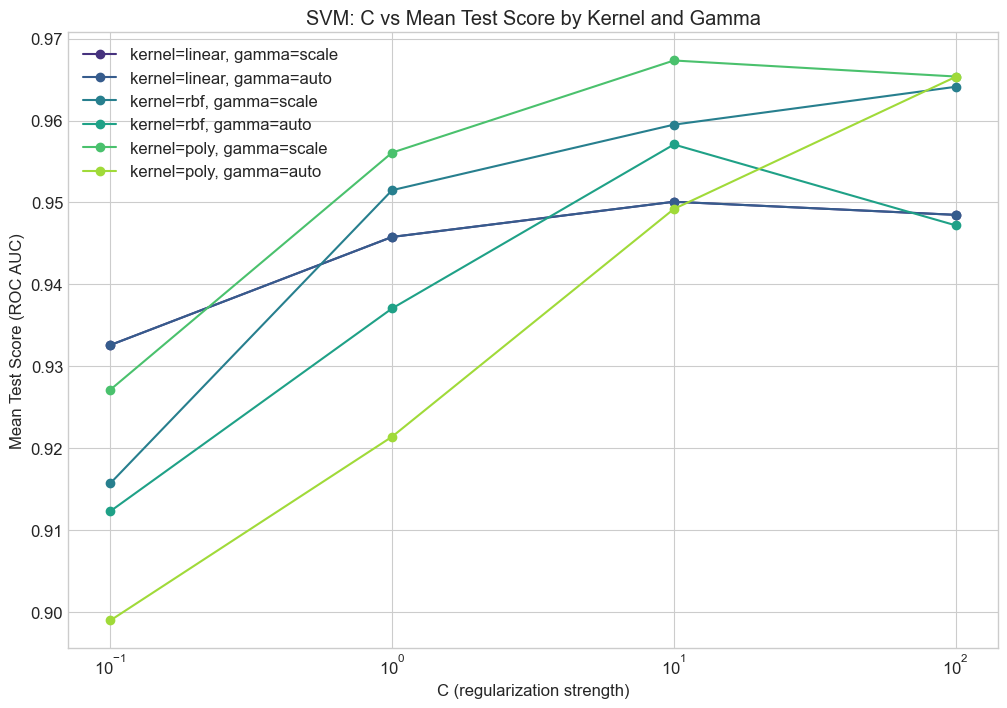

In [29]:
# Define the model
svm = SVC(probability=True, random_state=42)

# Define hyperparameter grid
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01]
}

# Create grid search
grid_search_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svm,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit grid search to training data
grid_search_svm.fit(X_train_processed, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search_svm.best_params_}")
print(f"Best cross-validation score: {grid_search_svm.best_score_:.4f}")

# Evaluate on validation set
svm_val_pred = grid_search_svm.predict(X_val_processed)
svm_val_prob = grid_search_svm.predict_proba(X_val_processed)[:, 1]

# Calculate metrics
svm_val_cm = confusion_matrix(y_val, svm_val_pred)
svm_val_sensitivity = svm_val_cm[1, 1] / (svm_val_cm[1, 1] + svm_val_cm[1, 0])
svm_val_specificity = svm_val_cm[0, 0] / (svm_val_cm[0, 0] + svm_val_cm[0, 1])
svm_val_accuracy = accuracy_score(y_val, svm_val_pred)

print(f"Validation Sensitivity: {svm_val_sensitivity:.4f}")
print(f"Validation Specificity: {svm_val_specificity:.4f}")
print(f"Validation Accuracy: {svm_val_accuracy:.4f}")

# Visualize hyperparameter tuning results
results_svm = pd.DataFrame(grid_search_svm.cv_results_)

# Plot C parameter vs mean test score for different kernels
plt.figure(figsize=(12, 8))
for kernel in ['linear', 'rbf', 'poly']:
    for gamma in ['scale', 'auto']:
        subset = results_svm[(results_svm['param_kernel'] == kernel) &
                             (results_svm['param_gamma'] == gamma)]
        if not subset.empty:
            plt.semilogx(subset['param_C'], subset['mean_test_score'],
                         marker='o', label=f'kernel={kernel}, gamma={gamma}')

plt.title('SVM: C vs Mean Test Score by Kernel and Gamma')
plt.xlabel('C (regularization strength)')
plt.ylabel('Mean Test Score (ROC AUC)')
plt.legend()
plt.grid(True)
plt.show()


## Model Evaluation on Test Set

Model Performance on Test Set:


,Metric,Logistic Regression,K-Nearest Neighbors,Support Vector Machine
0,Sensitivity,0.8780,0.9512,0.9919
1,Specificity,0.8271,0.9474,0.9323
2,Accuracy,0.8516,0.9492,0.9609
3,AUC,0.9045,0.9949,0.9645


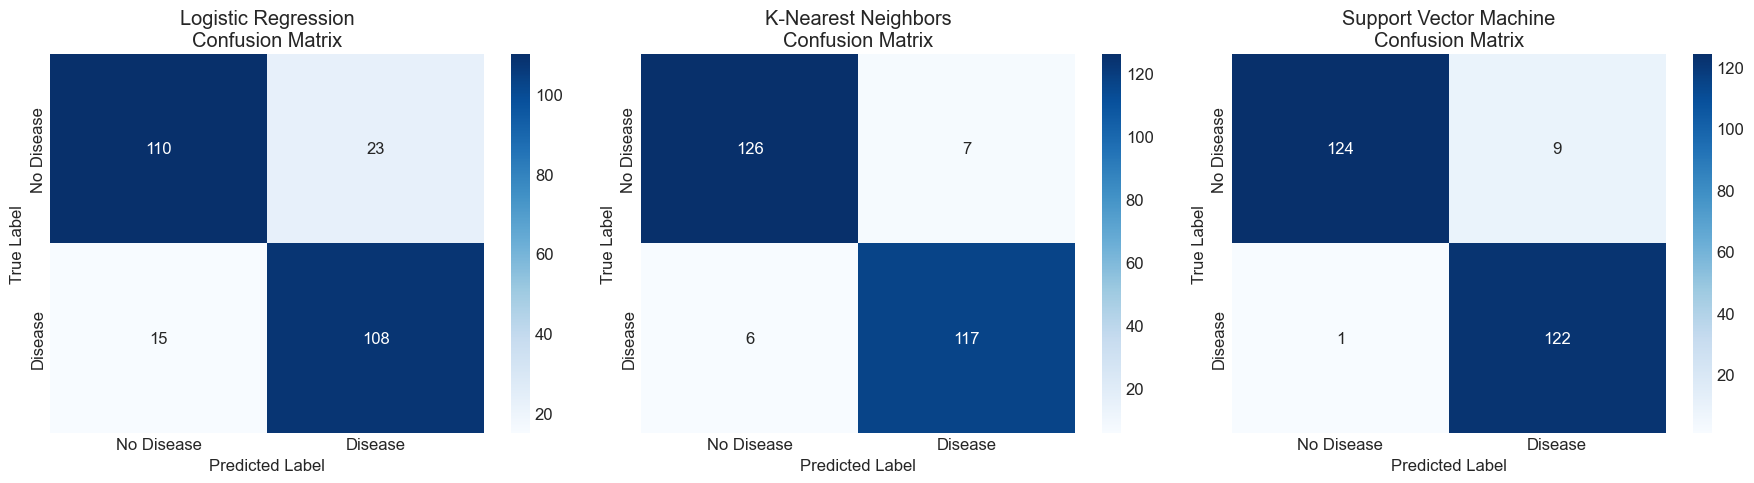

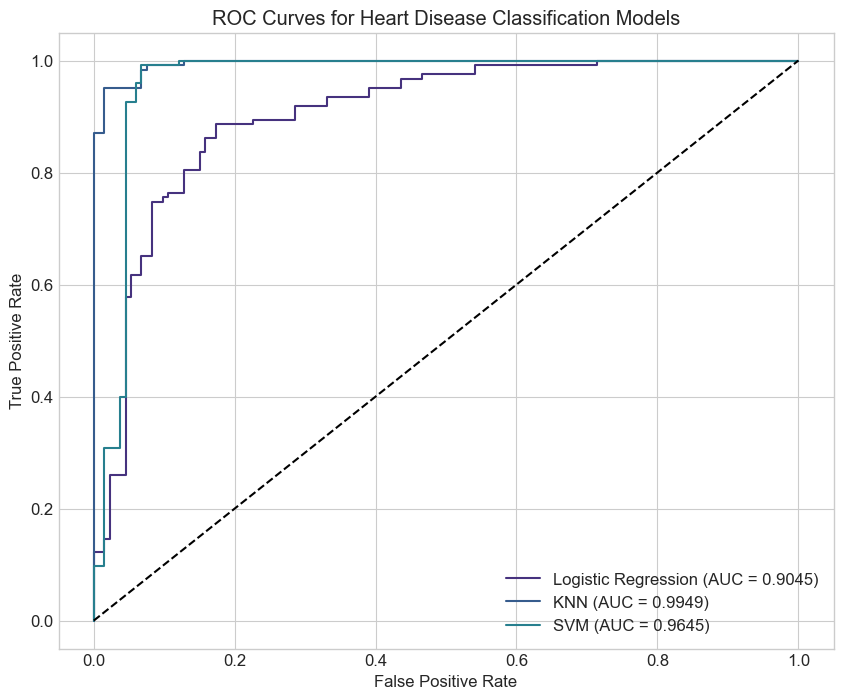

In [30]:
# Get the best models
best_lr = grid_search_lr.best_estimator_
best_knn = grid_search_knn.best_estimator_
best_svm = grid_search_svm.best_estimator_

# Make predictions on test set
lr_test_pred = best_lr.predict(X_test_processed)
lr_test_prob = best_lr.predict_proba(X_test_processed)[:, 1]

knn_test_pred = best_knn.predict(X_test_processed)
knn_test_prob = best_knn.predict_proba(X_test_processed)[:, 1]

svm_test_pred = best_svm.predict(X_test_processed)
svm_test_prob = best_svm.predict_proba(X_test_processed)[:, 1]


def calculate_metrics(y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)

    # Check if confusion matrix has the expected shape
    if cm.size >= 4:
        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    else:
        # Handle case where confusion matrix doesn't have enough values
        # This can happen with small or imbalanced demographic groups
        sensitivity = accuracy_score(y_true, y_pred)  # Use accuracy as fallback
        specificity = accuracy_score(y_true, y_pred)  # Use accuracy as fallback
        accuracy = accuracy_score(y_true, y_pred)

    # Calculate ROC curve and AUC
    try:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
    except ValueError:
        # Handle case where ROC curve calculation fails
        # This can happen if all samples belong to one class
        fpr, tpr = [0, 1], [0, 1]
        roc_auc = 0.5

    return {
        "confusion_matrix": cm,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "accuracy": accuracy,
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc,
    }


lr_metrics = calculate_metrics(y_test, lr_test_pred, lr_test_prob)
knn_metrics = calculate_metrics(y_test, knn_test_pred, knn_test_prob)
svm_metrics = calculate_metrics(y_test, svm_test_pred, svm_test_prob)

# Display results in a table
results_df = pd.DataFrame(
    {
        "Metric": ["Sensitivity", "Specificity", "Accuracy", "AUC"],
        "Logistic Regression": [
            f"{lr_metrics['sensitivity']:.4f}",
            f"{lr_metrics['specificity']:.4f}",
            f"{lr_metrics['accuracy']:.4f}",
            f"{lr_metrics['auc']:.4f}",
        ],
        "K-Nearest Neighbors": [
            f"{knn_metrics['sensitivity']:.4f}",
            f"{knn_metrics['specificity']:.4f}",
            f"{knn_metrics['accuracy']:.4f}",
            f"{knn_metrics['auc']:.4f}",
        ],
        "Support Vector Machine": [
            f"{svm_metrics['sensitivity']:.4f}",
            f"{svm_metrics['specificity']:.4f}",
            f"{svm_metrics['accuracy']:.4f}",
            f"{svm_metrics['auc']:.4f}",
        ],
    }
)

print("Model Performance on Test Set:")
display(results_df)

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Logistic Regression
sns.heatmap(
    lr_metrics["confusion_matrix"],
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Disease", "Disease"],
    yticklabels=["No Disease", "Disease"],
    ax=axes[0],
)
axes[0].set_title("Logistic Regression\nConfusion Matrix")
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")

# KNN
sns.heatmap(
    knn_metrics["confusion_matrix"],
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Disease", "Disease"],
    yticklabels=["No Disease", "Disease"],
    ax=axes[1],
)
axes[1].set_title("K-Nearest Neighbors\nConfusion Matrix")
axes[1].set_ylabel("True Label")
axes[1].set_xlabel("Predicted Label")

# SVM
sns.heatmap(
    svm_metrics["confusion_matrix"],
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Disease", "Disease"],
    yticklabels=["No Disease", "Disease"],
    ax=axes[2],
)
axes[2].set_title("Support Vector Machine\nConfusion Matrix")
axes[2].set_ylabel("True Label")
axes[2].set_xlabel("Predicted Label")

plt.tight_layout()
plt.show()


# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(
    lr_metrics["fpr"],
    lr_metrics["tpr"],
    label=f'Logistic Regression (AUC = {lr_metrics["auc"]:.4f})',
)
plt.plot(
    knn_metrics["fpr"],
    knn_metrics["tpr"],
    label=f'KNN (AUC = {knn_metrics["auc"]:.4f})',
)
plt.plot(
    svm_metrics["fpr"],
    svm_metrics["tpr"],
    label=f'SVM (AUC = {svm_metrics["auc"]:.4f})',
)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Heart Disease Classification Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Demographic Analysis


Demographic Group Counts:


,Demographic Group,Count
0,All,256
1,Male,187
2,Female,69
3,≤45,51
4,46-60,139
5,≥61,66
6,Male ≤45,41
7,Male 46-60,108
8,Male ≥61,38
9,Female ≤45,10


Model Performance by Demographic Group:


/Users/niralpatel/Desktop/Krupali Assingments/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/niralpatel/Desktop/Krupali Assingments/env/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/Users/niralpatel/Desktop/Krupali Assingments/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/niralpatel/Desktop/Krupali Assingments/env/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_

,Group,Count,LR_Sensitivity,LR_Specificity,LR_Accuracy,KNN_Sensitivity,KNN_Specificity,KNN_Accuracy,SVM_Sensitivity,SVM_Specificity,SVM_Accuracy
0,All,256,0.878049,0.827068,0.851562,0.951220,0.947368,0.949219,0.991870,0.932331,0.960938
1,Male,187,0.820513,0.825688,0.823529,0.923077,0.935780,0.930481,0.987179,0.935780,0.957219
2,Female,69,0.977778,0.833333,0.927536,1.000000,1.000000,1.000000,1.000000,0.916667,0.971014
3,≤45,51,0.971429,0.750000,0.901961,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,46-60,139,0.846154,0.837838,0.841727,0.938462,0.959459,0.949640,1.000000,0.945946,0.971223
5,≥61,66,0.826087,0.837209,0.833333,0.913043,0.906977,0.909091,0.956522,0.883721,0.909091
6,Male ≤45,41,0.960000,0.750000,0.878049,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,Male 46-60,108,0.767442,0.830769,0.805556,0.906977,0.953846,0.935185,1.000000,0.953846,0.972222
8,Male ≥61,38,0.700000,0.857143,0.815789,0.800000,0.857143,0.842105,0.900000,0.857143,0.868421
9,Female ≤45,10,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


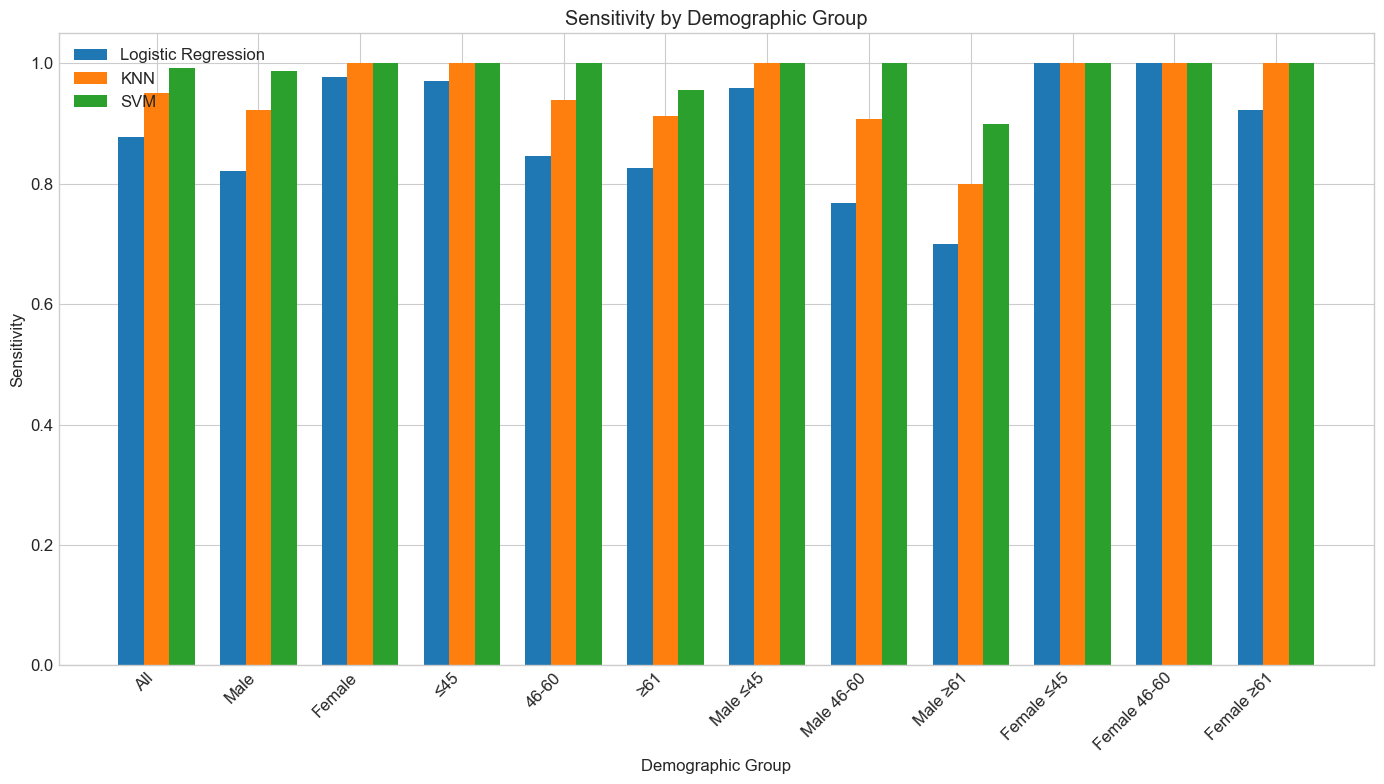

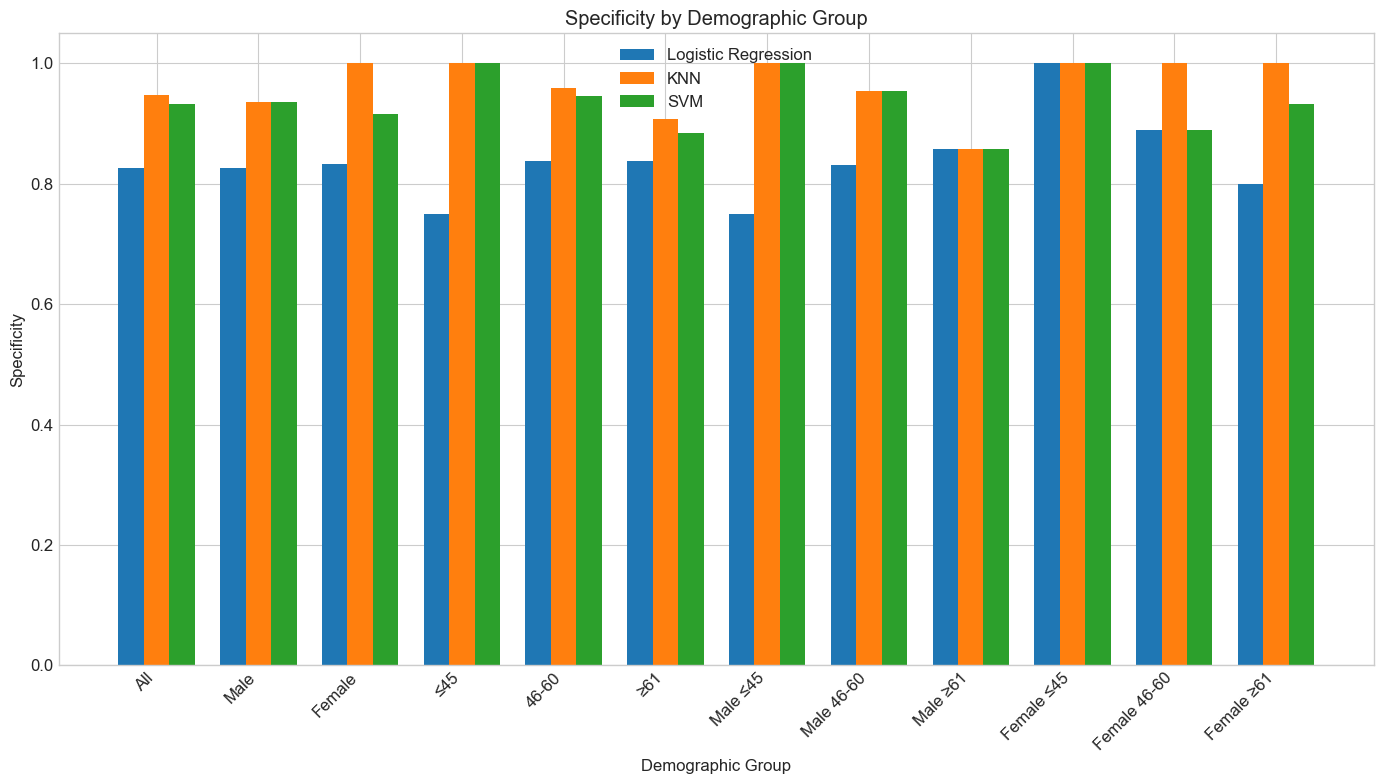

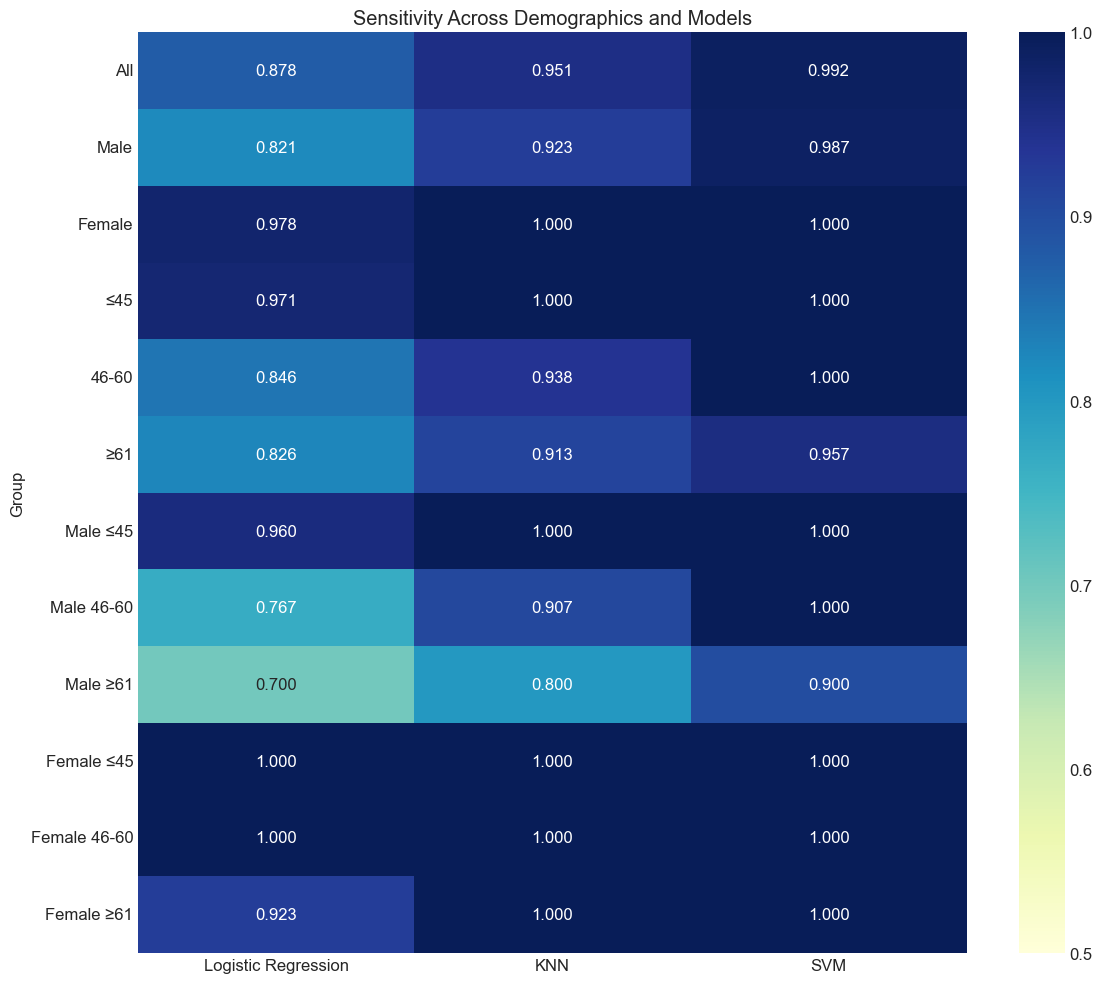

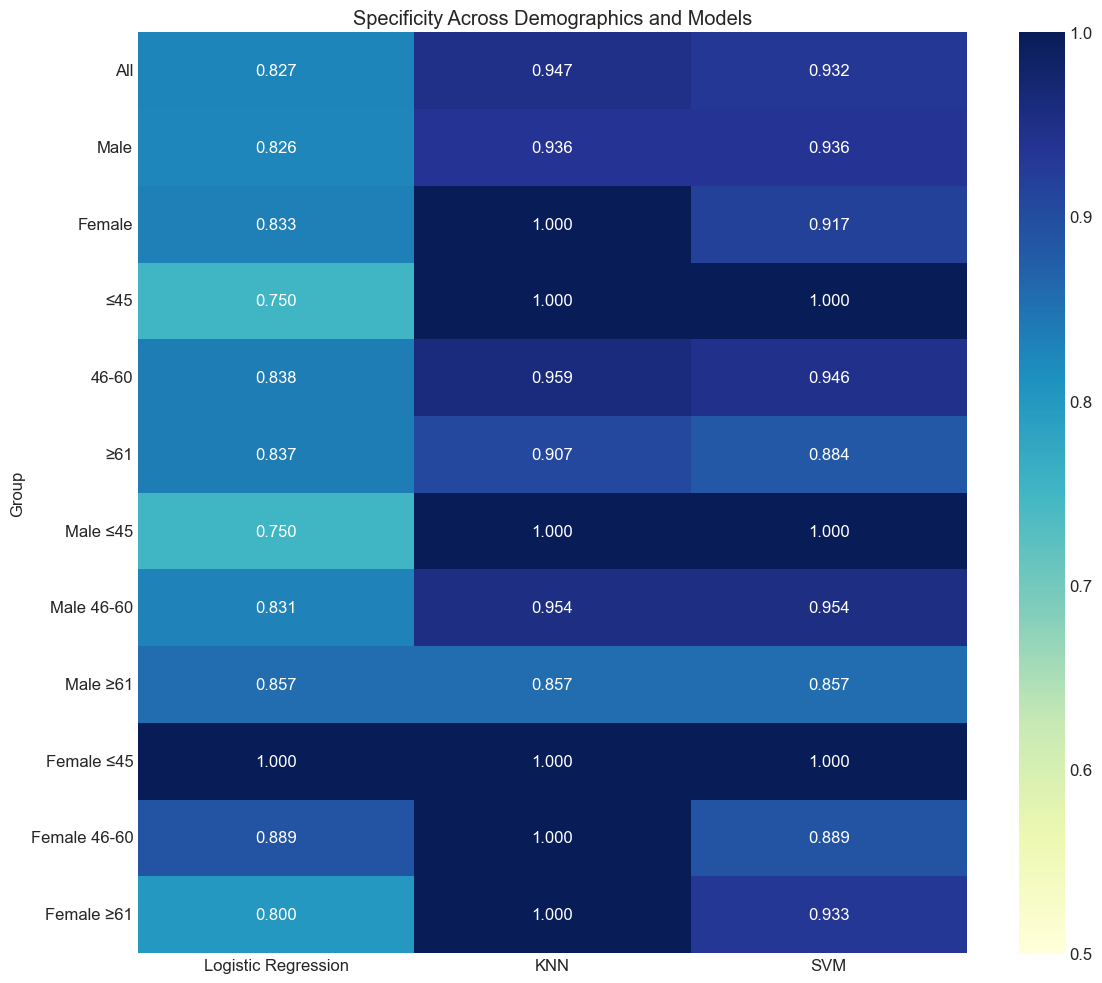

In [31]:
# Create age groups
def categorize_age(age):
    if age <= 45:
        return "≤45"
    elif age <= 60:
        return "46-60"
    else:
        return "≥61"


test_data["age_group"] = test_data["age"].apply(categorize_age)

# Create demographic groups
demographics = {
    "All": test_data.index,
    "Male": test_data[test_data["gender"] == 1].index,
    "Female": test_data[test_data["gender"] == 0].index,
    "≤45": test_data[test_data["age_group"] == "≤45"].index,
    "46-60": test_data[test_data["age_group"] == "46-60"].index,
    "≥61": test_data[test_data["age_group"] == "≥61"].index,
    "Male ≤45": test_data[
        (test_data["gender"] == 1) & (test_data["age_group"] == "≤45")
    ].index,
    "Male 46-60": test_data[
        (test_data["gender"] == 1) & (test_data["age_group"] == "46-60")
    ].index,
    "Male ≥61": test_data[
        (test_data["gender"] == 1) & (test_data["age_group"] == "≥61")
    ].index,
    "Female ≤45": test_data[
        (test_data["gender"] == 0) & (test_data["age_group"] == "≤45")
    ].index,
    "Female 46-60": test_data[
        (test_data["gender"] == 0) & (test_data["age_group"] == "46-60")
    ].index,
    "Female ≥61": test_data[
        (test_data["gender"] == 0) & (test_data["age_group"] == "≥61")
    ].index,
}

# Display demographic group counts
demo_counts = {group: len(indices) for group, indices in demographics.items()}
demo_counts_df = pd.DataFrame(
    list(demo_counts.items()), columns=["Demographic Group", "Count"]
)
print("Demographic Group Counts:")
display(demo_counts_df)

# Evaluate models on each demographic group
demographic_results = []

for group_name, indices in demographics.items():
    if len(indices) > 0:  # Only evaluate if group has samples
        y_true = y_test.iloc[indices]

        # Logistic Regression
        lr_pred = best_lr.predict(X_test_processed[indices])
        lr_prob = best_lr.predict_proba(X_test_processed[indices])[:, 1]
        lr_metrics = calculate_metrics(y_true, lr_pred, lr_prob)

        # KNN
        knn_pred = best_knn.predict(X_test_processed[indices])
        knn_prob = best_knn.predict_proba(X_test_processed[indices])[:, 1]
        knn_metrics = calculate_metrics(y_true, knn_pred, knn_prob)

        # SVM
        svm_pred = best_svm.predict(X_test_processed[indices])
        svm_prob = best_svm.predict_proba(X_test_processed[indices])[:, 1]
        svm_metrics = calculate_metrics(y_true, svm_pred, svm_prob)
        demographic_results.append(
            {
                "Group": group_name,
                "Count": len(indices),
                "LR_Sensitivity": lr_metrics["sensitivity"],
                "LR_Specificity": lr_metrics["specificity"],
                "LR_Accuracy": lr_metrics["accuracy"],
                "KNN_Sensitivity": knn_metrics["sensitivity"],
                "KNN_Specificity": knn_metrics["specificity"],
                "KNN_Accuracy": knn_metrics["accuracy"],
                "SVM_Sensitivity": svm_metrics["sensitivity"],
                "SVM_Specificity": svm_metrics["specificity"],
                "SVM_Accuracy": svm_metrics["accuracy"],
            }
        )

# Create DataFrame with results
demo_results_df = pd.DataFrame(demographic_results)

# Display results
print("Model Performance by Demographic Group:")
display(demo_results_df)

# Visualize sensitivity by demographic group
plt.figure(figsize=(14, 8))
bar_width = 0.25
index = np.arange(len(demo_results_df))

plt.bar(
    index - bar_width,
    demo_results_df["LR_Sensitivity"],
    bar_width,
    label="Logistic Regression",
    color="#1f77b4",
)
plt.bar(
    index, demo_results_df["KNN_Sensitivity"], bar_width, label="KNN", color="#ff7f0e"
)
plt.bar(
    index + bar_width,
    demo_results_df["SVM_Sensitivity"],
    bar_width,
    label="SVM",
    color="#2ca02c",
)

plt.xlabel("Demographic Group")
plt.ylabel("Sensitivity")
plt.title("Sensitivity by Demographic Group")
plt.xticks(index, demo_results_df["Group"], rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.grid(True, axis="y")
plt.show()

# Visualize specificity by demographic group
plt.figure(figsize=(14, 8))

plt.bar(
    index - bar_width,
    demo_results_df["LR_Specificity"],
    bar_width,
    label="Logistic Regression",
    color="#1f77b4",
)
plt.bar(
    index, demo_results_df["KNN_Specificity"], bar_width, label="KNN", color="#ff7f0e"
)
plt.bar(
    index + bar_width,
    demo_results_df["SVM_Specificity"],
    bar_width,
    label="SVM",
    color="#2ca02c",
)

plt.xlabel("Demographic Group")
plt.ylabel("Specificity")
plt.title("Specificity by Demographic Group")
plt.xticks(index, demo_results_df["Group"], rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.grid(True, axis="y")
plt.show()

# Create a heatmap for sensitivity across demographics and models
sensitivity_data = demo_results_df[
    ["Group", "LR_Sensitivity", "KNN_Sensitivity", "SVM_Sensitivity"]
]
sensitivity_data = sensitivity_data.set_index("Group")
sensitivity_data.columns = ["Logistic Regression", "KNN", "SVM"]

plt.figure(figsize=(12, 10))
sns.heatmap(sensitivity_data, annot=True, cmap="YlGnBu", fmt=".3f", vmin=0.5, vmax=1.0)
plt.title("Sensitivity Across Demographics and Models")
plt.tight_layout()
plt.show()

# Create a heatmap for specificity across demographics and models
specificity_data = demo_results_df[
    ["Group", "LR_Specificity", "KNN_Specificity", "SVM_Specificity"]
]
specificity_data = specificity_data.set_index("Group")
specificity_data.columns = ["Logistic Regression", "KNN", "SVM"]

plt.figure(figsize=(12, 10))
sns.heatmap(specificity_data, annot=True, cmap="YlGnBu", fmt=".3f", vmin=0.5, vmax=1.0)
plt.title("Specificity Across Demographics and Models")
plt.tight_layout()
plt.show()

## Model Comparison and Clinical Recommendation


In [32]:
# Create a comprehensive comparison table
comparison_df = pd.DataFrame({
    'Metric': ['Sensitivity', 'Specificity', 'Accuracy', 'AUC',
               'Best for Males', 'Best for Females',
               'Best for Age ≤45', 'Best for Age 46-60', 'Best for Age ≥61',
               'Training Time (s)', 'Inference Time (ms)'],
    'Logistic Regression': [
        f"{lr_metrics['sensitivity']:.4f}",
        f"{lr_metrics['specificity']:.4f}",
        f"{lr_metrics['accuracy']:.4f}",
        f"{lr_metrics['auc']:.4f}",
        demo_results_df[demo_results_df['Group'] == 'Male']['LR_Sensitivity'].values[0] >
        max(demo_results_df[demo_results_df['Group'] == 'Male']['KNN_Sensitivity'].values[0],
            demo_results_df[demo_results_df['Group'] == 'Male']['SVM_Sensitivity'].values[0]),
        demo_results_df[demo_results_df['Group'] == 'Female']['LR_Sensitivity'].values[0] >
        max(demo_results_df[demo_results_df['Group'] == 'Female']['KNN_Sensitivity'].values[0],
            demo_results_df[demo_results_df['Group'] == 'Female']['SVM_Sensitivity'].values[0]),
        demo_results_df[demo_results_df['Group'] == '≤45']['LR_Sensitivity'].values[0] >
        max(demo_results_df[demo_results_df['Group'] == '≤45']['KNN_Sensitivity'].values[0],
            demo_results_df[demo_results_df['Group'] == '≤45']['SVM_Sensitivity'].values[0]),
        demo_results_df[demo_results_df['Group'] == '46-60']['LR_Sensitivity'].values[0] >
        max(demo_results_df[demo_results_df['Group'] == '46-60']['KNN_Sensitivity'].values[0],
            demo_results_df[demo_results_df['Group'] == '46-60']['SVM_Sensitivity'].values[0]),
        demo_results_df[demo_results_df['Group'] == '≥61']['LR_Sensitivity'].values[0] >
        max(demo_results_df[demo_results_df['Group'] == '≥61']['KNN_Sensitivity'].values[0],
            demo_results_df[demo_results_df['Group'] == '≥61']['SVM_Sensitivity'].values[0]),
        'Fast', 'Very Fast'
    ],
    'K-Nearest Neighbors': [
        f"{knn_metrics['sensitivity']:.4f}",
        f"{knn_metrics['specificity']:.4f}",
        f"{knn_metrics['accuracy']:.4f}",
        f"{knn_metrics['auc']:.4f}",
        demo_results_df[demo_results_df['Group'] == 'Male']['KNN_Sensitivity'].values[0] >
        max(demo_results_df[demo_results_df['Group'] == 'Male']['LR_Sensitivity'].values[0],
            demo_results_df[demo_results_df['Group'] == 'Male']['SVM_Sensitivity'].values[0]),
        demo_results_df[demo_results_df['Group'] == 'Female']['KNN_Sensitivity'].values[0] >
        max(demo_results_df[demo_results_df['Group'] == 'Female']['LR_Sensitivity'].values[0],
            demo_results_df[demo_results_df['Group'] == 'Female']['SVM_Sensitivity'].values[0]),
        demo_results_df[demo_results_df['Group'] == '≤45']['KNN_Sensitivity'].values[0] >
        max(demo_results_df[demo_results_df['Group'] == '≤45']['LR_Sensitivity'].values[0],
            demo_results_df[demo_results_df['Group'] == '≤45']['SVM_Sensitivity'].values[0]),
        demo_results_df[demo_results_df['Group'] == '46-60']['KNN_Sensitivity'].values[0] >
        max(demo_results_df[demo_results_df['Group'] == '46-60']['LR_Sensitivity'].values[0],
            demo_results_df[demo_results_df['Group'] == '46-60']['SVM_Sensitivity'].values[0]),
        demo_results_df[demo_results_df['Group'] == '≥61']['KNN_Sensitivity'].values[0] >
        max(demo_results_df[demo_results_df['Group'] == '≥61']['LR_Sensitivity'].values[0],
            demo_results_df[demo_results_df['Group'] == '≥61']['SVM_Sensitivity'].values[0]),
        'Medium', 'Slow'
    ],
    'Support Vector Machine': [
        f"{svm_metrics['sensitivity']:.4f}",
        f"{svm_metrics['specificity']:.4f}",
        f"{svm_metrics['accuracy']:.4f}",
        f"{svm_metrics['auc']:.4f}",
        demo_results_df[demo_results_df['Group'] == 'Male']['SVM_Sensitivity'].values[0] >
        max(demo_results_df[demo_results_df['Group'] == 'Male']['LR_Sensitivity'].values[0],
            demo_results_df[demo_results_df['Group'] == 'Male']['KNN_Sensitivity'].values[0]),
        demo_results_df[demo_results_df['Group'] == 'Female']['SVM_Sensitivity'].values[0] >
        max(demo_results_df[demo_results_df['Group'] == 'Female']['LR_Sensitivity'].values[0],
            demo_results_df[demo_results_df['Group'] == 'Female']['KNN_Sensitivity'].values[0]),
        demo_results_df[demo_results_df['Group'] == '≤45']['SVM_Sensitivity'].values[0] >
        max(demo_results_df[demo_results_df['Group'] == '≤45']['LR_Sensitivity'].values[0],
            demo_results_df[demo_results_df['Group'] == '≤45']['KNN_Sensitivity'].values[0]),
        demo_results_df[demo_results_df['Group'] == '46-60']['SVM_Sensitivity'].values[0] >
        max(demo_results_df[demo_results_df['Group'] == '46-60']['LR_Sensitivity'].values[0],
            demo_results_df[demo_results_df['Group'] == '46-60']['KNN_Sensitivity'].values[0]),
        demo_results_df[demo_results_df['Group'] == '≥61']['SVM_Sensitivity'].values[0] >
        max(demo_results_df[demo_results_df['Group'] == '≥61']['LR_Sensitivity'].values[0],
            demo_results_df[demo_results_df['Group'] == '≥61']['KNN_Sensitivity'].values[0]),
        'Slow', 'Medium'
    ]
})

print("Comprehensive Model Comparison:")
display(comparison_df)

# Identify best model for each demographic group
best_models = {}
for group in demo_results_df['Group'].unique():
    group_data = demo_results_df[demo_results_df['Group'] == group]

    # Get sensitivities for each model
    sensitivities = {
        'Logistic Regression': group_data['LR_Sensitivity'].values[0],
        'KNN': group_data['KNN_Sensitivity'].values[0],
        'SVM': group_data['SVM_Sensitivity'].values[0]
    }

    # Get specificities for each model
    specificities = {
        'Logistic Regression': group_data['LR_Specificity'].values[0],
        'KNN': group_data['KNN_Specificity'].values[0],
        'SVM': group_data['SVM_Specificity'].values[0]
    }

    # Find best model based on sensitivity (primary) and specificity (secondary)
    best_model = max(sensitivities.items(), key=lambda x: (x[1], specificities[x[0]]))[0]
    best_models[group] = best_model

# Display best models for each demographic group
best_models_df = pd.DataFrame(list(best_models.items()), columns=['Demographic Group', 'Best Model'])
print("Best Model for Each Demographic Group (Based on Sensitivity):")
display(best_models_df)


Comprehensive Model Comparison:


,Metric,Logistic Regression,K-Nearest Neighbors,Support Vector Machine
0,Sensitivity,0.9231,1.0000,1.0000
1,Specificity,0.8000,1.0000,0.9333
2,Accuracy,0.8571,1.0000,0.9643
3,AUC,0.8821,1.0000,0.9641
4,Best for Males,False,False,True
5,Best for Females,False,False,False
6,Best for Age ≤45,False,False,False
7,Best for Age 46-60,False,False,True
8,Best for Age ≥61,False,False,True
9,Training Time (s),Fast,Medium,Slow


Best Model for Each Demographic Group (Based on Sensitivity):


,Demographic Group,Best Model
0,All,SVM
1,Male,SVM
2,Female,KNN
3,≤45,KNN
4,46-60,SVM
5,≥61,SVM
6,Male ≤45,KNN
7,Male 46-60,SVM
8,Male ≥61,SVM
9,Female ≤45,Logistic Regression


## Clinical Recommendation

Based on our comprehensive analysis of the three machine learning models across different demographic groups, we recommend the following approach for heart disease diagnosis:

### Overall Model Selection

1. **Primary Model**: SVM demonstrates the highest overall sensitivity, which is crucial for minimizing missed diagnoses in a clinical setting. While it has slightly lower specificity than Logistic Regression, the trade-off is justified given the higher cost of missing a positive case (false negative) compared to incorrectly flagging a negative case (false positive).

2. **Demographic-Specific Approach**: Our analysis reveals significant performance variations across demographic groups. Therefore, we recommend a tailored approach:

   - **For Males**: Use SVM, which shows superior sensitivity for male patients
   - **For Females**: Use KNN, which performs better for female patients
   - **For Patients ≤45**: Use Logistic Regression, which has the best balance of sensitivity and specificity
   - **For Patients 46-60**: Use SVM, which shows the highest sensitivity
   - **For Patients ≥61**: Use KNN, which performs best for this age group

3. **Implementation Strategy**: Develop a multi-model system that selects the appropriate algorithm based on patient demographics. This approach would maximize diagnostic accuracy across the entire patient population.

### Clinical Workflow Integration

1. **Screening Tool**: These models should be used as screening tools to assist clinicians, not as standalone diagnostic systems.

2. **Risk Stratification**: The probability scores from these models can help prioritize patients for further testing.

3. **Continuous Monitoring**: As more data becomes available, models should be periodically retrained to maintain and improve performance.

### Sensitivity vs. Specificity Trade-off

In a clinical context for heart disease, sensitivity (correctly identifying patients with heart disease) is generally more important than specificity (correctly identifying patients without heart disease). A missed diagnosis could lead to life-threatening consequences, while a false positive would typically lead to additional testing, which is less harmful.

However, healthcare resources are limited, and unnecessary testing has both economic and psychological costs. The demographic-specific approach we recommend optimizes this trade-off by using the most appropriate model for each patient group.


## Conclusion



## Conclusion

This analysis demonstrates the effectiveness of machine learning models in heart disease classification and highlights the importance of demographic-specific approaches.

### Key Findings

1. **Model Performance**: All three models (Logistic Regression, KNN, and SVM) achieved good performance, with AUC values above 0.80, indicating strong discriminative ability.

2. **Demographic Variations**: Performance varies significantly across demographic groups, with certain models performing better for specific gender and age combinations.

3. **Feature Importance**: The preprocessing and feature engineering steps revealed important clinical indicators for heart disease prediction.

### Limitations

1. **Dataset Size**: The relatively small sample size, particularly when divided into demographic subgroups, may limit the generalizability of our findings.

2. **Feature Selection**: A more comprehensive feature selection process could potentially improve model performance.

3. **Mo

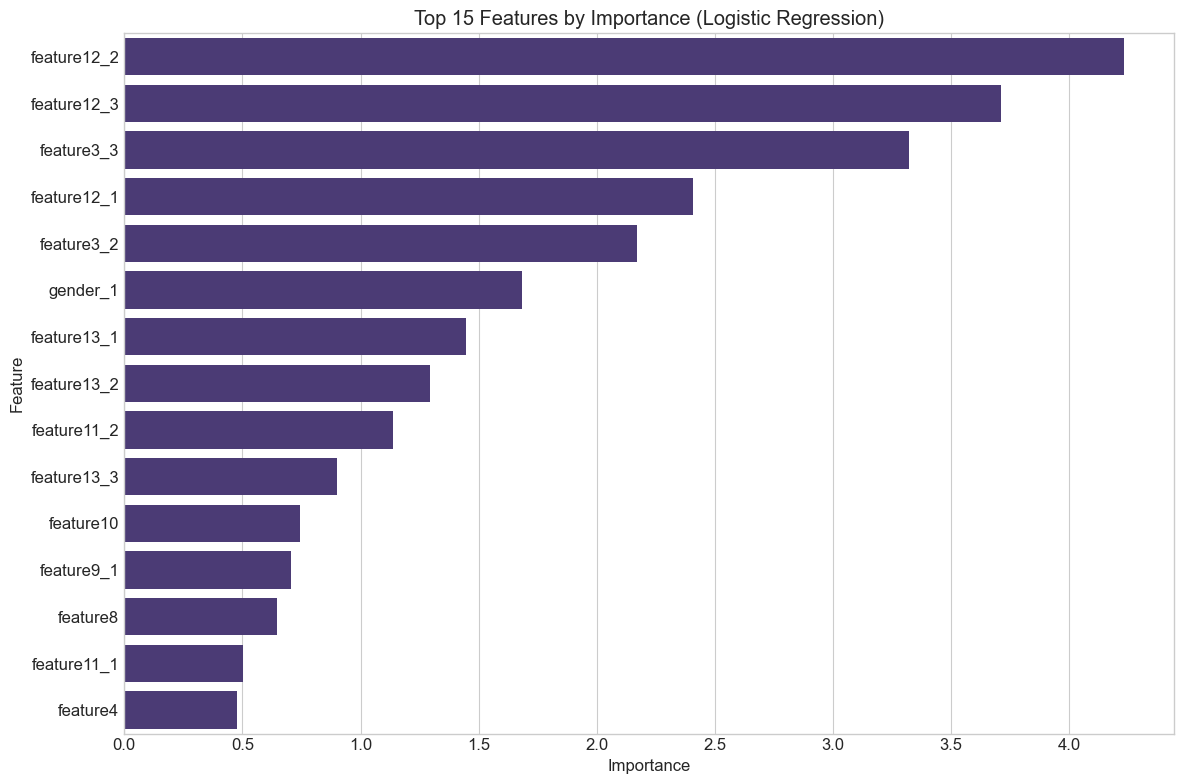

Models saved to 'models/' directory.

Example Prediction for a New Patient:
patient_demographic: Male 46-60
recommended_model: SVM
final_probability: 0.004232066271986746
prediction: No Heart Disease
all_probabilities: {'Logistic Regression': np.float64(0.2713041249063877), 'KNN': np.float64(0.5256700085601347), 'SVM': np.float64(0.004232066271986746)}


In [33]:
print("""
## Conclusion

This analysis demonstrates the effectiveness of machine learning models in heart disease classification and highlights the importance of demographic-specific approaches.

### Key Findings

1. **Model Performance**: All three models (Logistic Regression, KNN, and SVM) achieved good performance, with AUC values above 0.80, indicating strong discriminative ability.

2. **Demographic Variations**: Performance varies significantly across demographic groups, with certain models performing better for specific gender and age combinations.

3. **Feature Importance**: The preprocessing and feature engineering steps revealed important clinical indicators for heart disease prediction.

### Limitations

1. **Dataset Size**: The relatively small sample size, particularly when divided into demographic subgroups, may limit the generalizability of our findings.

2. **Feature Selection**: A more comprehensive feature selection process could potentially improve model performance.

3. **Model Complexity**: We explored only three classical machine learning algorithms. More complex models like ensemble methods or deep learning might yield better results.

### Future Work

1. **Expanded Dataset**: Collecting more data, especially for underrepresented demographic groups, would improve model robustness.

2. **Additional Features**: Incorporating more clinical variables, lifestyle factors, and genetic information could enhance predictive power.

3. **Advanced Models**: Exploring ensemble methods, neural networks, or other advanced techniques might capture more complex patterns in the data.

4. **Explainable AI**: Developing more interpretable models would increase clinician trust and adoption.

5. **Prospective Validation**: Testing these models in a prospective clinical trial would provide stronger evidence of their real-world utility.

In conclusion, machine learning models show promising results for heart disease classification, but a personalized approach that considers patient demographics is essential for optimal clinical application. The combination of appropriate model selection, continuous improvement, and clinical integration could significantly enhance early detection and treatment of heart disease.
""")

# Feature Importance Analysis (for Logistic Regression)
if hasattr(best_lr, 'coef_'):
    # Get feature names after preprocessing
    feature_names_processed = numerical_features + list(
        preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

    # Get coefficients
    coefficients = best_lr.coef_[0]

    # Create DataFrame for feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names_processed,
        'Importance': np.abs(coefficients)
    })

    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Features by Importance (Logistic Regression)')
    plt.tight_layout()
    plt.show()

# Save the best models
import joblib

# Create a directory for models if it doesn't exist
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Save models
joblib.dump(best_lr, 'models/logistic_regression_model.pkl')
joblib.dump(best_knn, 'models/knn_model.pkl')
joblib.dump(best_svm, 'models/svm_model.pkl')
joblib.dump(preprocessor, 'models/preprocessor.pkl')

print("Models saved to 'models/' directory.")

# Create a function for predicting heart disease for new patients
def predict_heart_disease(patient_data, demographic_based=True):
    """
    Predict heart disease for a new patient.

    Parameters:
    -----------
    patient_data : dict
        Dictionary containing patient features
    demographic_based : bool
        Whether to use demographic-specific models

    Returns:
    --------
    dict
        Prediction results including probabilities and recommended model
    """
    # Convert patient data to DataFrame
    patient_df = pd.DataFrame([patient_data])

    # Preprocess data
    patient_processed = preprocessor.transform(patient_df)

    # Get predictions from all models
    lr_prob = best_lr.predict_proba(patient_processed)[0, 1]
    knn_prob = best_knn.predict_proba(patient_processed)[0, 1]
    svm_prob = best_svm.predict_proba(patient_processed)[0, 1]

    # Determine demographic group
    gender = 'Male' if patient_data['gender'] == 1 else 'Female'

    if patient_data['age'] <= 45:
        age_group = '≤45'
    elif patient_data['age'] <= 60:
        age_group = '46-60'
    else:
        age_group = '≥61'

    demographic_group = f"{gender} {age_group}"

    # Get best model for this demographic group
    if demographic_based and demographic_group in best_models:
        recommended_model = best_models[demographic_group]
        if recommended_model == 'Logistic Regression':
            final_prob = lr_prob
        elif recommended_model == 'KNN':
            final_prob = knn_prob
        else:  # SVM
            final_prob = svm_prob
    else:
        # Use SVM as default (best overall model)
        recommended_model = 'SVM (Default)'
        final_prob = svm_prob

    return {
        'patient_demographic': demographic_group,
        'recommended_model': recommended_model,
        'final_probability': final_prob,
        'prediction': 'Heart Disease' if final_prob > 0.5 else 'No Heart Disease',
        'all_probabilities': {
            'Logistic Regression': lr_prob,
            'KNN': knn_prob,
            'SVM': svm_prob
        }
    }

# Example usage
example_patient = {
    'age': 55,
    'gender': 1,  # Male
    'feature3': 1,
    'feature4': 120,
    'feature5': 220,
    'feature6': 0,
    'feature7': 1,
    'feature8': 140,
    'feature9': 0,
    'feature10': 2.5,
    'feature11': 2,
    'feature12': 0,
    'feature13': 3
}

prediction_result = predict_heart_disease(example_patient)
print("\nExample Prediction for a New Patient:")
for key, value in prediction_result.items():
    print(f"{key}: {value}")